# Data Mining - Mini Lab
### Team 2 - Patricia Goresen, Jeffrey Lancon, Brychan Manry, George Sturrock
#### June 17, 2018
------

## Introduction
#### Data Description
The sujbect matter for this Lab assignment is team level data from the Lahman baseball database.  The database was described in detail during Lab 1.  The team summarized team level statistics generated in Lab 1 is used as the input data set for this study.  The team level data was summarized from approximately 30,000 rows of data from team level statistics dating back to 1970 and payroll data.  
#### Objective
The ultimate objective is to find the best model to predict if a team will make the Playoffs given the available statistical data.  To meet this objective, this section will examine three different models to determine which produce the best accuracy, recall and precision scores.  The three models are:  
    - GridSearchCV Logistic Regression with manual variable reduction
    - GridSearchCV Logistic Regression with recursive feature elimination
    - Support Vector Machine
#### Approach
First, the input data set will have categorical features with little value (ball park name and disparate database identifiers) removed.  Features with near zero variance (such as games played) will also be removed.  Features which introduce leakage (such as Wins and how far a team progressed in the playoffs) will be removed as well.  The data will then be split into a explanatory ("X") and response ("Y") dataframes to feed into the different models.   

The "GridSearchCV Logistic Regression with manual feature reduction" model will start begin remaining explanatory variables and use correlation scores, variable inflation factors and significance scores to manually reduce the number of features input into the regression function.

The "GridSearchCV Logistic Regression with recursive feature elimination" and "Support Vector Machine" models will also have the remaining explanatory variables input into it's pipeline for analysis.  The team will allow the recursive feature elimination function and Support Vector Machine to determine which features to include in the end model on with no intervention.  

Model accuracy, recall and precision will be used to determine which model yields the best results to predict whether or not a team will make the Major League Baseball Playoffs.  

------

## Create Models
### Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

team = pd.read_csv('./data/teams2Plus.csv')

#Convert Y/N playoff flag to 1/0 indicator
team['Playoff'] = team['Playoff'].map({'Y':1, 'N':0})

#Drop records with missing values in the Playoff column
team = team[np.isfinite(team['Playoff'])]
team.Playoff = team.Playoff.astype(int)

#Store all franchise IDs per row for future references
allfranchID = team['franchID']

#Create Y Response Variable DF
teamY = team['Playoff']

#Drop Categorial Columns with no predictive ability
team = team.drop(['teamIDBR', 'teamIDlahman45', 'teamIDretro', 'G', 'teamID', 'Ghome', 'name', 'park', 'lgID', 'divID', 'salary', 'attendance', 'Playoff'], axis=1)

#Drop Columns which introduce leakage
team = team.drop(['LgWin', 'DivWin', 'WCWin', 'WSWin', 'W', 'L', 'Rank'], axis=1)

#Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

#Also create Test set for 2017
team2017 = team.loc[team['yearID'] == 2017]
franchid2017 = team2017['franchID']

#Drop last categorial column now that it has been preserved
team = team.drop(['franchID'], axis=1)
team2017 = team2017.drop(['franchID'], axis=1)

#Create X Explanatory Variables DF to support the individual models
teamX = team
teamXRfecv = team
teamXSVM = team
teamXRfecv = teamXRfecv.drop(['Unnamed: 0'], axis=1)
teamXSVM = teamXSVM.drop(['Unnamed: 0'], axis=1)
print("teamXRfecv", teamXRfecv.info())
print("teamXSVM", teamXSVM.info())

print("Team DF")
team.info()
#teamX_colNames = list(teamX)

print("Team 2017")
team2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1323
Data columns (total 36 columns):
yearID    1296 non-null int64
R         1296 non-null int64
AB        1296 non-null int64
H         1296 non-null int64
2B        1296 non-null int64
3B        1296 non-null int64
HR        1296 non-null int64
BB        1296 non-null float64
SO        1296 non-null float64
SB        1296 non-null float64
CS        1296 non-null float64
HBP       1296 non-null float64
SF        1296 non-null float64
RA        1296 non-null int64
ER        1296 non-null int64
ERA       1296 non-null float64
CG        1296 non-null int64
SHO       1296 non-null int64
SV        1296 non-null int64
IPouts    1296 non-null int64
HA        1296 non-null int64
HRA       1296 non-null int64
BBA       1296 non-null int64
SOA       1296 non-null int64
E         1296 non-null int64
DP        1296 non-null int64
FP        1296 non-null float64
BPF       1296 non-null int64
PPF       1296 non-null int64
WHIP   

In [2]:
#Last check for NA values
team.isnull().sum()

Unnamed: 0    0
yearID        0
R             0
AB            0
H             0
2B            0
3B            0
HR            0
BB            0
SO            0
SB            0
CS            0
HBP           0
SF            0
RA            0
ER            0
ERA           0
CG            0
SHO           0
SV            0
IPouts        0
HA            0
HRA           0
BBA           0
SOA           0
E             0
DP            0
FP            0
BPF           0
PPF           0
WHIP          0
KBB           0
KAB           0
Bavg          0
Slug          0
OBP           0
OPS           0
dtype: int64

#### Colinearity
As determined in Lab 1, colinearity is an issue in this data set.  Highly correlated and redundant features will be removed from the input into the "GridSearchCV Logistic Regression with manual variable reduction" model.  Though colinearity is a objective measurement, some subjective descretion will be exercised when removing features.  

##### Starting Colinearity

In [3]:
#Create correlation matrix
teamCorrMat = team.corr()

# Highest Correlation Pairs
corrPairs = teamCorrMat.unstack().sort_values(kind="quicksort")
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

FP          E            -0.958084
CG          yearID       -0.828620
            Unnamed: 0   -0.820053
SHO         ERA          -0.669942
WHIP        SHO          -0.651043
                            ...   
KAB         SO            0.973806
OPS         Slug          0.974699
BPF         PPF           0.978014
RA          ER            0.985641
Unnamed: 0  yearID        0.999068
Length: 666, dtype: float64


##### Ending Colinearity

In [4]:
#Drop highly correlated, insignificant and high VIF columns.
teamX = team.drop(['CS', 'BB', 'SB', '2B', '3B', 'BBA', 'DP', 'HR', 'yearID', 'WHIP', 'HA', 'HBP', 'Slug', 'SF', 'OPS', 'Bavg', 'SOA', 'KAB', 'SHO', 'FP', 'E', 'ER', 'IPouts', 'SO', 'BPF', 'PPF', 'Unnamed: 0', 'ERA', 'H'], axis=1)

#Create correlation matrix
teamCorrMat = teamX.corr()

# Highest Correlation Pairs
corrPairs = teamCorrMat.unstack().sort_values(kind="quicksort")
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

SV   CG    -0.521343
HRA  CG    -0.517123
KBB  CG    -0.450180
CG   RA    -0.330862
R    CG    -0.233253
              ...   
AB   RA     0.494169
HRA  R      0.524398
R    AB     0.578170
RA   HRA    0.743288
OBP  R      0.814649
Length: 28, dtype: float64


#### Scale Data
It is critical to scale this data set for input into each of the three models in this report.  Several features in the data set are decimal measurements that will never exceed 1.  The realistic range of Batting Average is approximately 0.21 to 0.3.  Other features such as attendence could range from tens of thousands to hundreds of thousands.  

In [5]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
teamX_scaled = scaler.fit_transform(teamX)
teamXRfecv_scaled = scaler.fit_transform(teamXRfecv)
teamXSVM_scaled = scaler.fit_transform(teamXSVM)

#Save as data frames
df_teamX_scaled = pd.DataFrame(teamX_scaled)
df_teamXRfecv_scaled = pd.DataFrame(teamXRfecv_scaled)
df_teamXSVM_scaled = pd.DataFrame(teamXSVM_scaled)


#### Variance Inflation Factors (VIF)
VIF will also be addressed prior to running the "GridSearchCV Logistic Regression with manual variable reduction" model.  The starting VIF of the unscaled team data shows several features with high VIF Factors.
##### Beginning VIF

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(team.values, i) for i in range(team.shape[1])]
#df2_vif["features"] = df_teamX_scaled.columns
df2_vif["features"] = team.columns
df2_vif

,VIF Factor,features
0,1.077363e+03,Unnamed: 0
1,5.433994e+06,yearID
2,1.211189e+03,R
3,3.266656e+05,AB
4,2.297657e+05,H
5,4.792292e+03,2B
6,3.276009e+02,3B
7,1.407856e+04,HR
8,2.019001e+04,BB
9,3.838337e+04,SO


##### Ending VIF
After applying a threshold of 10, the VIF for data input into the manual Logistic Regression model has been reduced significantly.

In [7]:
#Credit to:
###https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python
###https://etav.github.io/python/vif_factor_python.html

#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_teamX_scaled.values, i) for i in range(df_teamX_scaled.shape[1])]
#df2_vif["features"] = df_teamX_scaled.columns
df2_vif["features"] = teamX.columns
df2_vif

,VIF Factor,features
0,8.395007,R
1,3.138265,AB
2,5.591007,RA
3,2.977814,CG
4,2.184272,SV
5,3.826117,HRA
6,2.447916,KBB
7,5.039360,OBP


#### Check Feature Significance

In [8]:
#Logistic Regression Summary table with full model fit prior to scaling, cross validation or recursive 
#feature elimination.
#Cursory check to verify feature significance

import statsmodels.api as sm
logit_model = sm.Logit(teamY, teamX)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.245847
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.484      
Dependent Variable: Playoff          AIC:              653.2342   
Date:               2018-06-17 19:57 BIC:              694.5705   
No. Observations:   1296             Log-Likelihood:   -318.62    
Df Model:           7                LL-Null:          -618.03    
Df Residuals:       1288             LLR p-value:      4.3796e-125
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
---------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
---------------------------------------------------------------------
R       0.0274      0.0022    12.5624    0.0000     0.0231     0.0317
AB     -0.0027      0.0005    -5.7628    

### Logistic Regresssion

#### Classifier Evaluation

In [9]:
#Credit To:  https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb

from sklearn.model_selection import cross_validate
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, teamX, teamY, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, teamX, teamY, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

#### GridSearchCV Logistic Regression with Manual Feature Reduction

In [10]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(teamX, teamY)
regGridSearch.fit(df_teamX_scaled, teamY)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    5.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [11]:
#Diplay the top model parameters
regGridSearch.best_estimator_.coef_

array([[ 2.60519102, -0.76252932, -1.97336804,  0.53512682,  1.0217957 ,
        -0.51143328,  0.46728398,  0.06831141]])

In [12]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, df_teamX_scaled, teamY, cv, "manual")

The average accuracy for all cv folds is: 			 0.89385
The average precision for all cv folds is: 			 0.76677
The average recall for all cv folds is: 			 0.60859
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.892308,0.736842,0.608696
1,0.888462,0.757576,0.543478
2,0.907692,0.822222,0.698113
3,0.888462,0.775510,0.678571
4,0.907692,0.833333,0.673077
5,0.900000,0.777778,0.608696
6,0.850000,0.725000,0.508772
7,0.896154,0.750000,0.558140
8,0.900000,0.789474,0.625000
9,0.907692,0.700000,0.583333


In [13]:
#Predictions using Grid Search CV
#print("Plain GridSearch Prediction")
#print(regGridSearch.predict(teamX))
#print(regGridSearch.predict_proba(teamX))
#print(regGridSearch.predict(df_teamX_scaled))
#print(regGridSearch.predict_proba(df_teamX_scaled))

#Is there a difference between .predict and .best_estimator_.predict?  Nope.
print("Best Estimator GridSearch Prediction")
#print(regGridSearch.best_estimator_.predict(teamX))
#print(regGridSearch.best_estimator_.predict_proba(teamX))
print(regGridSearch.best_estimator_.predict(df_teamX_scaled))
print(regGridSearch.best_estimator_.predict_proba(df_teamX_scaled))

Best Estimator GridSearch Prediction
[0 1 0 ... 0 0 1]
[[0.994294   0.005706  ]
 [0.08913697 0.91086303]
 [0.66284756 0.33715244]
 ...
 [0.99568585 0.00431415]
 [0.99548092 0.00451908]
 [0.26457073 0.73542927]]


#### GridSearchCV Logistic Regression with Recursive Feature Elimination

In [14]:
#Credit to:  Jake Drew NC Education Data Set Analysis

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit


print("RFECV Logistic Regression 1st Pass")
rfecvEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(df_teamXRfecv_scaled, teamY)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv, scoring='accuracy', verbose=1)
#X_BestFeatures = rfecv.fit_transform(teamX, teamY)
X_BestFeatures = rfecv.fit_transform(df_teamXRfecv_scaled, teamY)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Logistic Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

#Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(df_teamXRfecv_scaled, teamY)

RFECV Logistic Regression 1st Pass
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    7.4s finished


Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 fea

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.


Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__penalty': ['l2'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'logisticregression__class_weight': ['balanced', 'none'], 'logisticregression__random_state': [0], 'logisticregression__solver': ['lbfgs'], 'logisticregression__max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [15]:
#Use the best parameters from RFECV for our Linear Regression object
#rfecvClassifierEst = grid.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
#EvaluateClassifierEstimator(classifierEst, teamX, teamY, cv)
EvaluateClassifierEstimator(rfecvClassifierEst, df_teamXRfecv_scaled, teamY, cv, 'Rfecv')

The average accuracy for all cv folds is: 			 0.88846
The average precision for all cv folds is: 			 0.75864
The average recall for all cv folds is: 			 0.58567
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.892308,0.736842,0.608696
1,0.888462,0.757576,0.543478
2,0.884615,0.755556,0.641509
3,0.865385,0.723404,0.607143
4,0.900000,0.842105,0.615385
5,0.896154,0.787879,0.565217
6,0.853846,0.743590,0.508772
7,0.896154,0.750000,0.558140
8,0.900000,0.789474,0.625000
9,0.907692,0.700000,0.583333


In [16]:
#print(grid.best_estimator_.predict(teamX))
#print(grid.best_estimator_.predict_proba(teamX))
print(grid.best_estimator_.predict(df_teamXRfecv_scaled))
print(grid.best_estimator_.predict_proba(df_teamXRfecv_scaled))

[0 1 0 ... 0 0 1]
[[0.99643666 0.00356334]
 [0.07119376 0.92880624]
 [0.80903794 0.19096206]
 ...
 [0.99503012 0.00496988]
 [0.99604494 0.00395506]
 [0.31206208 0.68793792]]


### Support Vector Machine

In [17]:
#SVM for consolidated team level baseball data created in Lab 1.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

#scaler = StandardScaler()

#teamX_scaled = scaler.fit_transform(teamX)

#train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(df_teamXSVM_scaled, teamY)  # train object

y_hat = svm_clf.predict(df_teamXSVM_scaled)

acc = mt.accuracy_score(teamY,y_hat)
conf = mt.confusion_matrix(teamY,y_hat)
prec = mt.precision_score(teamY, y_hat)
recall = mt.recall_score(teamY, y_hat)
print('accuracy:', acc )
print('precision:', prec)
print('recall:', recall)
print(conf)

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': recall})

accuracy: 0.8865740740740741
precision: 0.837037037037037
recall: 0.47478991596638653
[[1036   22]
 [ 125  113]]


In [18]:
#look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


(484, 36)
(484,)
[257 227]


In [19]:
# SVM based Prediction
print(y_hat)

[0 1 0 ... 0 0 1]


### Create Model Summary
All three planned models were sucessfully implemented as planned.  All models utilized cross validation to control results.  Stochastic Gradient Descent was not utilized for the support vector machine model as the size of the data set did not warrant it use.  Good results were achieved by all models.  The "GridSearchCV Logistic Regression with manual variable reduction" model ultimately produced the best accuracy and overall results.  The results are summarized in the table below.

In [20]:
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Accuracy', 'Precision', 'Recall']]
df_results

,Model,Accuracy,Precision,Recall
0,manual,0.893846,0.766774,0.608588
1,Rfecv,0.888462,0.758643,0.585667
2,SVM,0.886574,0.837037,0.474790


## Model Advantages

Logistic regression and support vector machines are both machine learning models used for classification and regression analysis. Logistic regression's algorithm is centered on maximizing the probability of the data. The logistic regression model's accuracy is best when the data lies far from the separating line or hyperplane. The SVM algorithm is centered on finding the separating line or hyperplane that maximizes the distance the closest points are to the margin, known as the support vectors. These goals cause the logistic regression to be probabilistic, while SVMs are deterministic. We used two different types of logistic regression models. The first model used manual variable selection; we used correlation scores, variable inflation factors and significance scores to manually reduce the number of features input into the regression function. The manual logistic regression model time was much faster than the recursive feature elimination model. The recursive model repeatedly constructs a model and chooses the best or worst performing feature, puts that feature aside, then repeats the process until all variables have been analyzed. Since it analyzes every variable, this model takes more time to run than the manual model. Similarly, the SVM model analyses all variables so it also takes much more time to run the model.

Another aspect to evaluate is the amount of time needed to create, tune and optimize the models. The manual logistic regression model does use GridSearchCV to automate parameter selection. However, the individual features must be examined and tested manually to find the best model. This requires quite a bit of human capital to complete. Conversely, the RFE and SVM models do the feature selection automatically. After the initial programming is complete, the time needed to tune the RFE and SVM models is minimal compared to the manual model. In an agile environment, RFE and/or SVM could be used to produce a quality model quickly to solve a business problem while alternative models are being developed or prototyped.

There are advantages associated with both models. Overall, and as seen in our outcome, logistic regression and SVMs perform relatively similarly. We can see this in our accuracy, the logistic regression models and SVM model's accuracy are all within 1% accuracy of the other. The highest performing model in terms of accuracy was the manual logistic regression model with 89.39% accuracy. We can also compare these models in terms of precision and recall. Recall is defined as the correctly classified events to the number of all correct events. Precision measures the events correctly recalled to all events recalled; it is measuring how precise the recalls are. In our models, the precision was much higher in the SVM model with 83.7% precision. The logistic regression models performed very similarly to one another with manual having 76.71% precision and the RFE model having 75.86% precision. The manual logistic regression model performed much better than the others in terms of recall, 61.22%. The RFE model had a recall ratio of 58.56%, while the SVM only had a recall ratio of 47.47%. Comparing all three models, the manual logistic regression model seemed to perform the best for our data. It was faster than the other models, had the highest accuracy and recall, and performed very closely with precision.

The intended use of the model could also impact the decision. If the model is to serve a one-time need, the manual model would likely be the correct choice with it high accuracy and all-around results. However, if the model is intended to be implemented in a production environment and run on a routine basis, SVM and the RFE model may be a better choice. Both models can optimize feature selection as more data is collected with little human intervention. The manual model must be reviewed and maintained manually to assure optimal results are returned. In the end, the problem to be solved must be understood to select the appropriate classification model.


#### Key References

https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb (Logit)
http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf


### Feature Importance for Logistic Regression
By taking a closer look the feature weights in the logistic models we can get a better idea of which variables are the most important drivers of a team making it to the playoffs.

*need some interpretation for final models*

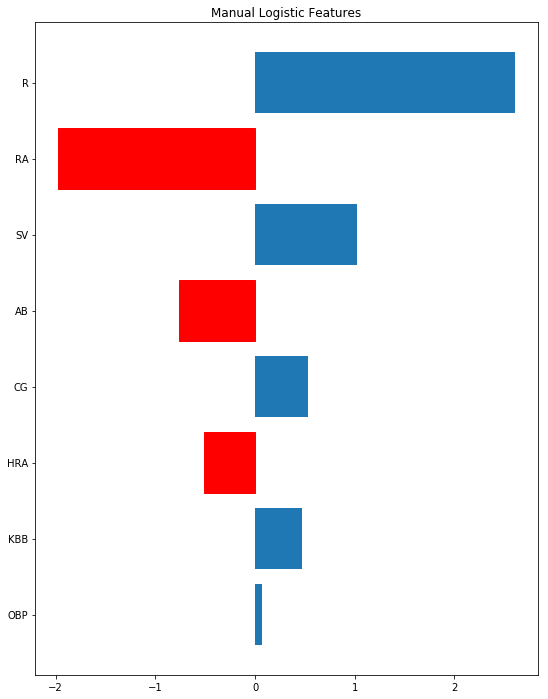

In [21]:
from matplotlib import pyplot as plt

def plotCoef(coef, names, t):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
    plt.figure(figsize=(9,12))
    barlist = plt.barh(range(len(names)), imp, align='center')
    for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
        barlist[x].set_color('r')
    plt.yticks(range(len(names)), names)
    plt.title(t)
    plt.show()

plotCoef(regGridSearch.best_estimator_.coef_[0], teamX.columns.values, "Manual Logistic Features")

In [22]:
list(sorted(zip(regGridSearch.best_estimator_.coef_.ravel(), teamX.columns.values)))

[(-1.9733680431522715, 'RA'),
 (-0.7625293211443834, 'AB'),
 (-0.5114332840188432, 'HRA'),
 (0.06831140574963632, 'OBP'),
 (0.46728398442347047, 'KBB'),
 (0.53512681572117, 'CG'),
 (1.0217957001327966, 'SV'),
 (2.605191019202166, 'R')]

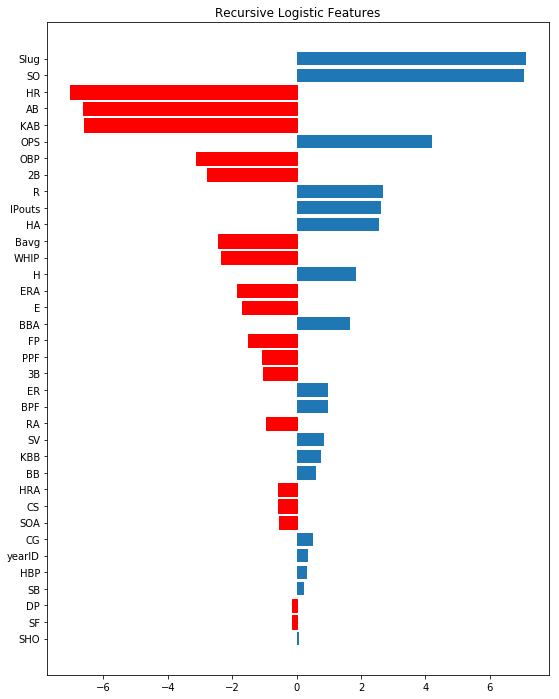

In [23]:
plotCoef(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), teamXRfecv.columns.values, "Recursive Logistic Features")

In [24]:
list(sorted(zip(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), teamXRfecv.columns.values)))

[(-7.036924357663255, 'HR'),
 (-6.625482449619146, 'AB'),
 (-6.6141848915954204, 'KAB'),
 (-3.109465062071774, 'OBP'),
 (-2.7941485351420763, '2B'),
 (-2.4494347708324367, 'Bavg'),
 (-2.351617447877606, 'WHIP'),
 (-1.8420924545396962, 'ERA'),
 (-1.6863303763279949, 'E'),
 (-1.5003473655213166, 'FP'),
 (-1.0743482258364394, 'PPF'),
 (-1.0395195711502057, '3B'),
 (-0.9628521206127816, 'RA'),
 (-0.5694957715325358, 'HRA'),
 (-0.5665150745815707, 'CS'),
 (-0.5384656993535823, 'SOA'),
 (-0.15782043208397895, 'DP'),
 (-0.134702041757356, 'SF'),
 (0.06577517856719536, 'SHO'),
 (0.22119864480433, 'SB'),
 (0.3296785989976615, 'HBP'),
 (0.3450757600241421, 'yearID'),
 (0.4937915989463838, 'CG'),
 (0.6003658671023974, 'BB'),
 (0.7551466425650996, 'KBB'),
 (0.8515926714721628, 'SV'),
 (0.9651705793684918, 'BPF'),
 (0.985573862382609, 'ER'),
 (1.6716831400993013, 'BBA'),
 (1.8517864903675552, 'H'),
 (2.5502913276257457, 'HA'),
 (2.6162058905496726, 'IPouts'),
 (2.6886098326042855, 'R'),
 (4.2053645

#### Interpreting SVM Fields
For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in  infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimentional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can ...?

**Dr. Larson mentions join plots, but I don't think these work very well or look very good for binary variables. Not sure what we want to do with these**
